In [298]:
#save default font settings
IPython_default = plt.rcParams.copy()

# set fonts / set text size
#@title matplotlib font settings
small_text = 15 #@param {type:"integer"}
medium_text = 26 #@param {type:"integer"}
large_text = 28 #@param {type:"integer"}
line_marker_size = 7 #@param {type:"slider", min:0, max:10, step:0.5}
legend_shadow = True #@param {type:"boolean"}
fig_width =  8 #@param {type:"number"}
fig_height =  6 #@param {type:"number"}
sns_style = "ticks" #@param ["darkgrid", "whitegrid", "dark", "white", "ticks"]
axis_grid = True #@param {type:"boolean"}
sns_palette = "deep" #@param ["pastel", "muted", "bright", "deep", "colorblind", "dark"]

import matplotlib.pyplot as plt
import seaborn as sns

# restore defaults
plt.rcdefaults()

#run configuration parameters
plt.rcParams['axes.labelsize']   = small_text
plt.rcParams['axes.titlesize']   = small_text
plt.rcParams['xtick.labelsize']  = small_text
plt.rcParams['ytick.labelsize']  = small_text
plt.rcParams['legend.fontsize']  = small_text
plt.rcParams['legend.shadow']    = legend_shadow
plt.rcParams['lines.markersize'] = line_marker_size
plt.rcParams['figure.figsize']   = (fig_width, fig_height)
plt.rcParams['font.size']        = small_text

# seaborn settings
sns.set_style(sns_style, {"axes.grid": axis_grid})
sns.set_palette(sns_palette)


# Download Embeddings

In [51]:
import os
import tqdm
import requests
import zipfile

URL = 'http://nlp.stanford.edu/data/glove.840B.300d.zip'

def fetch_data(url=URL,target_file='/content/drive/MyDrive/Colab Notebooks/chatbot-flask-simple/embeddings/glove.zip', delete_zip=False):
    # if dataset exists exit
    if os.path.isfile(target_file):
        print('datasets already downloaded')
        return

        #download (large) zip file
    #for large https request on stream mode to avoid out of memory issues
    #see : http://masnun.com/2016/09/18/python-using-the-requests-module-to-download-large-files-efficiently.html
    print("**************************")
    print("  Downloading zip file")
    print("  >_<  Please wait >_< ")
    print("**************************")
    response = requests.get(url, stream=True)
    #read chunk by chunk
    handle = open(target_file, "wb")
    for chunk in tqdm.tqdm(response.iter_content(chunk_size=512)):
        if chunk:  
            handle.write(chunk)
    handle.close()  
    print("  Download completed ;) :") 
    #extract zip_file
    zf = zipfile.ZipFile(target_file)
    print("1. Extracting {} file".format(target_file))
    zf.extractall(path='/content/drive/MyDrive/Colab Notebooks/chatbot-flask-simple/embeddings')
    if delete_zip:
        print("2. Deleting {} file".format(dataset_name+".zip"))
        os.remove(path=zip_file)

fetch_data()

datasets already downloaded


# Imports

In [99]:
import os
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import json
import pickle

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD
import random
from sklearn import preprocessing


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Set Variables

In [100]:
MODEL_NAME1 = 'best_model_scratch.h5'
MODEL_NAME2 = 'best_model_pretrained.h5'
model_path = '/content/drive/MyDrive/Colab Notebooks/chatbot-flask-simple/models'

model_path_scratch = os.path.join(model_path, MODEL_NAME1)
model_path_pretrained = os.path.join(model_path, MODEL_NAME2)

intents_path = '/content/drive/MyDrive/Colab Notebooks/chatbot-flask-simple/data/intents'

# inference model variables
inference_load_intents_from = os.path.join(intents_path, 'intents_job_intents.json')

words = []
tags = []
classes = []
documents = []
all_patterns = []
all_tags = []
label_encoded_Y = []
x_tr_seq = []
x_val_seq = []
y_tr = []
y_val = []
ignore_words = ['?', '!']

# Load JSON

In [101]:
data_file = open(inference_load_intents_from, encoding='cp1252').read()
intents = json.loads(data_file)

## Read in patterns and tags

Patterns are the user input (i.e., 'Hi,' 'How are you?').

Nothing is tokenized here.

In [102]:
# print classes
for intent in intents['intents']:
    all_patterns.extend(intent['patterns'])
    for pattern in intent['patterns']:
        all_tags.append(intent['tag'])
        w = nltk.word_tokenize(pattern)
        words.extend(w)
        documents.append((w, intent['tag']))

        if intent['tag'] not in classes:
            classes.append(intent['tag'])

words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))
classes = sorted(list(set(classes)))

print(len(documents), 'documents')
print(len(classes), 'classes', classes)
print(len(words), 'unique lemmatized words', words)

print(all_tags)
print(all_patterns)

61 documents
11 classes ['compliment', 'feeling', 'goodbye', 'greeting', 'manager', 'name', 'package_tracking', 'profane', 'return_product', 'thanks', 'tracking']
88 unique lemmatized words ["'", "'s", ',', '.', '0983834298342341', '1234509873234323', '1983-2343-2343-2343', 'a', 'am', 'are', 'back', 'broken', 'bye', 'can', 'computer', 'dead', 'device', 'die', 'do', 'doing', 'drop', 'equipment', 'feel', 'feeling', 'fix', 'fixed', 'get', 'give', 'go', 'going', 'good', 'goodbye', 'hate', 'have', 'hear', 'hello', 'help', 'helpful', 'here', 'hi', 'how', 'i', 'is', 'it', 'later', 'like', 'long', 'manager', 'me', 'money', 'my', 'name', 'need', 'not', 'now', 'package', 'product', 'refund', 'report', 'return', 'see', 'shipment', 'some', 'something', 'speak', 'speaking', 'supervisor', 'take', 'talk', 'thank', 'thanks', 'that', 'the', 'there', 'to', 'today', 'track', 'unhappy', 'very', 'want', 'what', 'where', 'who', 'whom', 'will', 'with', 'you', 'your']
['greeting', 'greeting', 'greeting', 'gre

## Encode Tags



### Fit

In [103]:
# create label encoder
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
# fit on all tags from JSON file
le.fit(all_tags)
print(f'Number of classes: {len(list(le.classes_))}')

Number of classes: 11


### Transform

In [104]:
label_encoded_Y = le.transform(all_tags)
print(f'Label_encoded_Y: {label_encoded_Y}')
print(f'Label_encoded_Y bincount: {np.bincount(label_encoded_Y)}')

Label_encoded_Y: [ 3  3  3  3  3  3  1  1  1  1  1  1  2  2  2  2  2  0  9  9  5  5  5  5
  4  4  4  4  4  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  6  6  6  6  6  6  7  7  7 10 10 10]
Label_encoded_Y bincount: [ 1  6  5  6  5  4  6  3 20  2  3]


## Create x_all, y_all

In [105]:
X_all = np.asarray(all_patterns)
y_all = np.asarray(label_encoded_Y)
print(f'X all shape: {X_all.shape}')
print(f'Y all shape: {y_all.shape}')
print(f'y_all: {y_all}')

X all shape: (61,)
Y all shape: (61,)
y_all: [ 3  3  3  3  3  3  1  1  1  1  1  1  2  2  2  2  2  0  9  9  5  5  5  5
  4  4  4  4  4  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  6  6  6  6  6  6  7  7  7 10 10 10]


# Tokenize

In [106]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(X_all))
print(tokenizer.word_index)
with open('/content/drive/MyDrive/Colab Notebooks/chatbot-flask-simple/data/intents/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

X_all_seq = tokenizer.texts_to_sequences(X_all)
print(X_all_seq)

{'i': 1, 'you': 2, 'to': 3, 'my': 4, 'want': 5, 'how': 6, 'your': 7, 'a': 8, 'are': 9, 'is': 10, 'product': 11, 'need': 12, 'package': 13, 'me': 14, 'can': 15, 'return': 16, 'track': 17, 'going': 18, 'am': 19, 'get': 20, 'refund': 21, 'money': 22, 'back': 23, 'computer': 24, 'broken': 25, '2343': 26, 'hello': 27, 'see': 28, 'where': 29, 'today': 30, 'it': 31, 'do': 32, 'have': 33, 'later': 34, 'name': 35, 'with': 36, 'manager': 37, 'give': 38, 'supervisor': 39, 'help': 40, 'fix': 41, 'hate': 42, 'hi': 43, 'good': 44, 'there': 45, 'hear': 46, 'doing': 47, "how's": 48, "'": 49, 'feeling': 50, 'feel': 51, 'go': 52, 'bye': 53, 'goodbye': 54, 'talk': 55, 'very': 56, 'helpful': 57, 'thanks': 58, 'thank': 59, 'what': 60, 'who': 61, 'whom': 62, 'speaking': 63, 'speak': 64, 'the': 65, 'report': 66, 'unhappy': 67, 'some': 68, 'equipment': 69, 'needs': 70, 'fixed': 71, 'something': 72, 'not': 73, 'like': 74, 'now': 75, 'device': 76, 'that': 77, 'long': 78, 'will': 79, 'take': 80, 'here': 81, 'shi

### Pad

In [107]:
# padding to prepare sequences of same length
X_all_seq = pad_sequences(X_all_seq, maxlen=25)
print(X_all_seq)
#type is now a numpy.ndarray
print(type(X_all_seq))
print(f'Shape (X_all): {X_all_seq.shape}')

[[ 0  0  0 ...  0  0 27]
 [ 0  0  0 ...  0  0 43]
 [ 0  0  0 ...  3 28  2]
 ...
 [ 0  0  0 ... 26 26 26]
 [ 0  0  0 ...  0  0 87]
 [ 0  0  0 ...  0  0 88]]
<class 'numpy.ndarray'>
Shape (X_all): (61, 25)


# Vocab Size

In [108]:
size_of_vocabulary = len(tokenizer.word_index) + 1 #+1 for padding
print(tokenizer.word_index)
print(f'Size of vocab: {size_of_vocabulary}')

{'i': 1, 'you': 2, 'to': 3, 'my': 4, 'want': 5, 'how': 6, 'your': 7, 'a': 8, 'are': 9, 'is': 10, 'product': 11, 'need': 12, 'package': 13, 'me': 14, 'can': 15, 'return': 16, 'track': 17, 'going': 18, 'am': 19, 'get': 20, 'refund': 21, 'money': 22, 'back': 23, 'computer': 24, 'broken': 25, '2343': 26, 'hello': 27, 'see': 28, 'where': 29, 'today': 30, 'it': 31, 'do': 32, 'have': 33, 'later': 34, 'name': 35, 'with': 36, 'manager': 37, 'give': 38, 'supervisor': 39, 'help': 40, 'fix': 41, 'hate': 42, 'hi': 43, 'good': 44, 'there': 45, 'hear': 46, 'doing': 47, "how's": 48, "'": 49, 'feeling': 50, 'feel': 51, 'go': 52, 'bye': 53, 'goodbye': 54, 'talk': 55, 'very': 56, 'helpful': 57, 'thanks': 58, 'thank': 59, 'what': 60, 'who': 61, 'whom': 62, 'speaking': 63, 'speak': 64, 'the': 65, 'report': 66, 'unhappy': 67, 'some': 68, 'equipment': 69, 'needs': 70, 'fixed': 71, 'something': 72, 'not': 73, 'like': 74, 'now': 75, 'device': 76, 'that': 77, 'long': 78, 'will': 79, 'take': 80, 'here': 81, 'shi

In [109]:
for doc in documents[:10]:
    print(doc[1])
    

greeting
greeting
greeting
greeting
greeting
greeting
feeling
feeling
feeling
feeling


# Load the Whole Embedding into Memory

In [61]:
# load the whole embedding into memory
path_to_glove_file = '/content/drive/MyDrive/Colab Notebooks/chatbot-flask-simple/embeddings/glove.840B.300d.txt'

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  


Found 2195884 word vectors.


In [110]:
# create a weight matrix for words in training docs
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((size_of_vocabulary, 300))
hits = 0
misses = 0
missedWords = []
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None and embedding_vector.shape[0] != 0:       
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
        missedWords.append(word)
print(f'Converted {hits} words ({misses} misses)')
print(missedWords)       


Converted 83 words (5 misses)
['to', 'is', "how's", '1234509873234323', '0983834298342341']


In [111]:
pickle.dump(words,open(os.path.join(intents_path, 'intents_words.pkl'),'wb'))
pickle.dump(classes,open(os.path.join(intents_path, 'intents_classes.pkl'),'wb'))
training = []
output_empty = [0] * len(classes)
for seq, doc in zip(X_all_seq, documents):
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1
    training.append([seq, output_row])

print(training)

[[array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, 27], dtype=int32), [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]], [array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, 43], dtype=int32), [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]], [array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0, 44,  3, 28,  2], dtype=int32), [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]], [array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0, 27, 45], dtype=int32), [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]], [array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0, 15,  2, 46, 14], dtype=int32), [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]], [array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0, 29,  9,  2], dtype=int32), [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]], [ar

In [112]:
random.shuffle(training)
training = np.array(training)
X_train_all = list(training[:,0])
y_train_all = list(training[:,1])
print(len(X_train_all))
print(len(y_train_all))

61
61


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


# Build Model

## Create model bag of words



In [113]:
# init training data
training_bow = []
output_empty = [0] * len(classes)
for doc in documents:
    bag = []
    pattern_words = doc[0]
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]

    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)

    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1

    training_bow.append([bag, output_row])

random.shuffle(training_bow)
training_bow = np.array(training_bow)
# create train and test lists.  X - patterns, y - intents
X_train_bag = list(training_bow[:,0])
y_train_bag = list(training_bow[:,1])
print('Training data created')
print(f'X train: {X_train_bag}')
print(f'y train: {y_train_bag}')


Training data created
X train: [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [114]:

def create_model_bag():

    model = Sequential()
    model.add(Dense(128, input_shape=(len(X_train_bag[0]),), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(y_train_bag[0]), activation='softmax'))

    # Compile model.  Stochastic gradient descent with Nesterov accelerated
    # gradient gives good
    # results for this model
    sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    print(model.summary())

    return model

# Create model scratch

In [142]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GlobalMaxPooling1D
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import numpy
from keras.callbacks import *
from keras.initializers import Constant

def create_model_scratch():
    model = Sequential()
    #embedding layer
    model.add(Embedding(size_of_vocabulary,300,
                        input_length=25,
                        trainable=True))
    #lstm layer
    model.add(LSTM(128,return_sequences=True,dropout=0.2))

    #Global Maxpooling
    model.add(GlobalMaxPooling1D())

    #Dense Layer
    model.add(Dense(64,activation='relu'))
    model.add(Dense(len(y_train_all[0]),activation='softmax'))

    #Add loss function, metrics, optimizer
    # Compile model.  Stochastic gradient descent with Nesterov accelerated
    # gradient gives good
    # results for this model
    sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

    #addingcallbacks
    #es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1000)
    #mc = ModelCheckpoint(model_path_scratch, monitor='val_accuracy', mode='max', 
                         #save_best_only=True, verbose=1)
    
    print(model.summary())

    return model

    


## Create pretrained model

In [143]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GlobalMaxPooling1D
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import numpy
from keras.callbacks import *
from keras.initializers import Constant

def create_model_pretrained():
    model = Sequential()
    #embedding layer
    model.add(Embedding(size_of_vocabulary,300,
                        input_length=25,
                        embeddings_initializer=Constant(embedding_matrix),
                        trainable=True))
    #lstm layer
    model.add(LSTM(128,return_sequences=True,dropout=0.2))

    #Global Maxpooling
    model.add(GlobalMaxPooling1D())

    #Dense Layer
    model.add(Dense(64,activation='relu'))
    model.add(Dense(len(y_train_all[0]),activation='softmax'))

    #Add loss function, metrics, optimizer
    # Compile model.  Stochastic gradient descent with Nesterov accelerated
    # gradient gives good
    # results for this model
    sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

    #addingcallbacks
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=1000)
    mc = ModelCheckpoint(model_path_pretrained, monitor='val_accuracy', mode='max', 
                         save_best_only=True, verbose=2)
    
    print(model.summary())

    return model

    


In [69]:
np.argmax(y_train_all, axis=1).shape

(61,)

# GRAPH

In [123]:
print(np.argmax(y_train_all, axis=1))

[ 4  8  6  8  8  4  3  0  8  9 10  6  8  8  8  5 10  3  6  8  8  3  8  8
  5  2  6  8  8  2  1  4  3  5  6  6  2  7  3  4  1  7  8  8  8  1  2  8
  4  1  9  5  8  2  8  8 10  1  3  1  7]


WordEmbeddings (pre-trained) <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f14f5284910>


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  1.8min remaining:  4.2min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


0.7523809523809524
WordEmbeddings (from scratch) <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f14f5284d90>


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  1.7min remaining:  4.1min


0.5761904761904761


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    6.0s remaining:   14.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.1s finished


label: ('BOW 0.640', 'WordEmbeddings (from scratch) 0.576', 'WordEmbeddings (pre-trained) 0.752'), handle: (<matplotlib.lines.Line2D object at 0x7f14fd500390>, <matplotlib.lines.Line2D object at 0x7f14f5235a90>, <matplotlib.lines.Line2D object at 0x7f14f53dc8d0>)


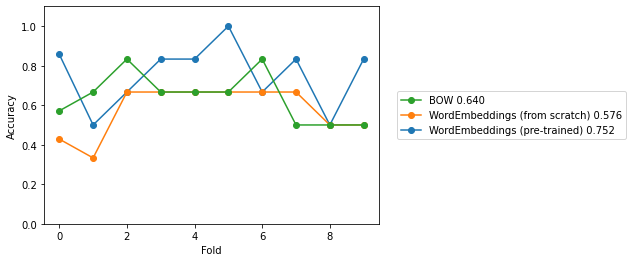

In [146]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier

pretrained = KerasClassifier(build_fn=create_model_pretrained, epochs=300,
                             batch_size=5, verbose=2)
scratch = KerasClassifier(build_fn=create_model_scratch, epochs=300, 
                          batch_size=5, verbose=2)
bag_of_words = KerasClassifier(build_fn=create_model_bag, epochs=300, 
                               batch_size=5, verbose=2)
classifiers = {'WordEmbeddings (pre-trained)': pretrained,
               'WordEmbeddings (from scratch)': scratch}

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

fig, ax = plt.subplots()
for name, model in classifiers.items():
    print(name, model)
    cv_scores = cross_val_score(model,
                                np.array(X_train_all), 
                                np.argmax(y_train_all, axis=1),
                                cv=kfold,
                                scoring='accuracy',
                                n_jobs=-1,
                                verbose=2)
    print(cv_scores.mean())
    my_lbl = f'{name} {cv_scores.mean():.3f}'
    ax.plot(cv_scores, '-o', label=my_lbl) 

cv_scores = cross_val_score(bag_of_words,
                           np.array(X_train_bag),
                           np.argmax(y_train_bag, axis=1),
                           cv=kfold,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=2)

my_lbl = f'BOW {cv_scores.mean():.3f}'
ax.plot(cv_scores, '-o', label=my_lbl) 
ax.set_ylim(0.0, 1.1)
ax.set_xlabel('Fold')
ax.set_ylabel('Accuracy')
handles, labels = ax.get_legend_handles_labels()
# sort both labels and handles by accuracy
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))   
print(f'label: {labels}, handle: {handles}')

ax.legend(handles, labels, ncol=1, bbox_to_anchor=(1.04,.5),loc='center left')

plt.show() 

In [147]:
pretrained.fit(np.array(X_train_all), np.argmax(y_train_all, axis=1))
pretrained.model.save(os.path.join(intents_path, 'pretrained_embeddings.h5'))

#model_save.save(os.path.join(intents_path, 'pretrained_embeddings.h5'))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 25, 300)           26700     
_________________________________________________________________
lstm_2 (LSTM)                (None, 25, 128)           219648    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 11)                715       
Total params: 255,319
Trainable params: 255,319
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/300
13/13 - 2s - loss: 2.3633 - accuracy: 0.2131
Epoch 2/300
13/13 - 0s - loss: 2.1717 - accuracy: 0.

In [89]:
print(np.argmax(y_train_bag, axis=1))

[ 8  2  2  1  6  2  8  8  8 10  8  3  8  8  8  8  6  1  9  4  7  6  5  8
  1  7  6  8  4  8 10  5  8  4  8  3 10  3  4  3  7  5  2  8  0  8  8  8
  8  9  6  2  1  3  5  4  8  1  3  6  1]


In [150]:
from keras import models
model = models.load_model(os.path.join(intents_path, 'pretrained_embeddings.h5'))
tokenizer = pickle.load(open(os.path.join(intents_path, 'tokenizer.pickle'), 'rb'))
tokenizer = tokenizer.texts_to_sequences(['Can you hear me?'])
sequence = pad_sequences(tokenizer, maxlen=25)
print(sequence)
res = model.predict(sequence)[0]
print(res)

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 15  2 46
  14]]
[5.87864133e-06 1.84937860e-04 6.06553622e-05 9.99703228e-01
 1.85693461e-05 1.23754335e-05 2.72331079e-07 5.24416782e-06
 1.63249553e-10 8.77201546e-06 4.73464787e-08]


In [90]:
print(X_train)

[array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  1, 12,  2,  3, 41,  4, 24], dtype=int32), array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0, 15,  2, 40, 14, 17,  4, 13], dtype=int32), array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6,
       78, 79,  4, 13, 80,  3, 20, 81], dtype=int32), array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0, 61,  9,  2], dtype=int32), array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  1, 12,  3, 16,  8, 13], dtype=int32), array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, 54], dtype=int32), array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  1, 12,  2,  3, 41, 72], dtype=int32), array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0

# Fit Model

In [ ]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5,shuffle=True, random_state=1)
lst_accu_stratified = []
for train_index, test_index in skf.split(X_all_seq, y_all):
    x_train_fold, x_test_fold = X_all_seq[train_index], X_all_seq[test_index]
    y_train_fold, y_test_fold = y_all[train_index], y_all[test_index]
    print(x_train_fold, y_train_fold)
    model.fit(np.array(x_train_fold),np.array(y_train_fold),batch_size=128,epochs=10,
              validation_data=(np.array(x_test_fold), np.array(y_test_fold)),
              verbose=1,callbacks=[es,mc])


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


[[ 0  0  0 ...  0  0 27]
 [ 0  0  0 ...  3 28  2]
 [ 0  0  0 ...  2 46 14]
 ...
 [ 0  0  0 ...  1 42  2]
 [ 0  0  0 ...  0  0 87]
 [ 0  0  0 ...  0  0 88]] [ 3  3  3  3  1  1  1  1  1  2  2  2  2  0  9  9  5  5  5  4  4  4  4  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  6  6  6  6  6  7  7 10 10]
Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.0000e+00 - acc: 0.1042 - val_loss: 0.0000e+00 - val_acc: 0.0769

Epoch 00001: val_acc improved from -inf to 0.07692, saving model to /content/drive/MyDrive/Colab Notebooks/chatbot-flask-simple/models/best_model_scratch.h5
Epoch 2/10
1/1 [==============================] - 0s 81ms/step - loss: 0.0000e+00 - acc: 0.1042 - val_loss: 0.0000e+00 - val_acc: 0.0769

Epoch 00002: val_acc did not improve from 0.07692
Epoch 3/10
1/1 [==============================] - 0s 77ms/step - loss: 0.0000e+00 - acc: 0.1042 - val_loss: 0.0000e+00 - val_acc: 0.0769

Epoch 00003: val_acc did not improve from 0.07692
Epoch 4/10
1/1 [============

In [305]:

# convert for k-fold sampling
X, y = X_all, y_all

from sklearn.model_selection import cross_val_score

model 
# Tokenize the sentences
#tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer()
for train, val in skf.split(X, y):
    print(f'train  - {np.bincount(y[train])} | test - {np.bincount(y[test])}')
    # preparing vocabulary
    tokenizer.fit_on_texts(list(X[train]))
    # convert text into integer sequences
    x_tr_seq.extend(tokenizer.texts_to_sequences(X[train]))
    x_val_seq.extend(tokenizer.texts_to_sequences(X[val]))
    y_tr.extend(y[train])
    y_val.extend(y[val])
   
    #print(x_tr_seq[:5])
    #print(x_val_seq[:5])
    #print(x_tr_seq)
    # padding to prepare sequences of same length
    #all_sequences = pad_sequences(all_sequences, maxlen=100)
x_tr_seq = pad_sequences(x_tr_seq, maxlen=100)
x_val_seq = pad_sequences(x_val_seq, maxlen=100)
size_of_vocabulary = len(tokenizer.word_index) + 1
print(tokenizer.word_index)
print(f' Size of vocab: {size_of_vocabulary}')
    #print(all_patterns.shape)
    #print(label_encoded_Y.shape)


NameError: ignored

In [ ]:
print(len(x_tr_seq))
print(len(y_tr))
print(len(x_val_seq))
print(len(y_val))

122
122
61
61


In [ ]:
MODEL_NAME1 = 'best_model_scratch.h5'
MODEL_NAME2 = 'best_model_pretrained.h5'
model_path = '/content/drive/MyDrive/Colab Notebooks/chatbot-flask-simple/models'

# build two different NLP models of the same architecture.  The first learns
# embeddings from scratch the second uses pretrained word embeddings
from keras.models import *
from keras.layers import *
from keras.callbacks import *

#training = os.path.join(data_path, TRAIN_CSV)
#validation = os.path.join(data_path, VALID_CSV)
model_path_scratch = os.path.join(model_path, MODEL_NAME1)
model_path_pretrained = os.path.join(model_path, MODEL_NAME2)

model = Sequential()
# Create model with 3 layers.  First layer 128 neurons, second layer 64 neurons
# and 3rd output layer contains number of neurons equal to number of intents to
# predict
# output intent with softmax
model = Sequential()
model.add(Dense(128, input_shape=(len(train_x[0]),), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation='softmax'))

# Compile model.  Stochastic gradient descent with Nesterov accelerated
# gradient gives good
# results for this model
sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

#embedding layer
model.add(Embedding(size_of_vocabulary,300,
                    weights=[embedding_matrix],
                    input_length=100,trainable=False))

#lstm layer
model.add(LSTM(128,return_sequences=True,dropout=0.2))

#Global Maxpooling
model.add(GlobalMaxPooling1D())

model.add(Dense(64,activation='relu'))
model.add(Dense(len(,activation='softmax'))

# add loss, metrics, optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['acc'])

# adding callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)
mc = ModelCheckpoint(model_path_pretrained, monitor='val_acc', mode='max', 
                     save_best_only=True,verbose=1)

#print summary of model
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 300)          26700     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 128)          219648    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 254,669
Trainable params: 227,969
Non-trainable params: 26,700
_________________________________________________________________
None


In [ ]:
y_tr = np.array(y_tr)
y_val = np.array(y_val)


In [ ]:
history = model.fit(np.array(x_tr_seq),np.array(y_tr),batch_size=128,epochs=10,
                    validation_data=(np.array(x_val_seq),np.array(y_val)),
                    verbose=1,callbacks=[es,mc])




Epoch 1/10
1/1 [==============================] - 0s 378ms/step - loss: 0.0000e+00 - acc: 0.0984 - val_loss: 0.0000e+00 - val_acc: 0.0984

Epoch 00001: val_acc did not improve from 0.09836
Epoch 2/10
1/1 [==============================] - 0s 329ms/step - loss: 0.0000e+00 - acc: 0.0984 - val_loss: 0.0000e+00 - val_acc: 0.0984

Epoch 00002: val_acc did not improve from 0.09836
Epoch 3/10
1/1 [==============================] - 0s 353ms/step - loss: 0.0000e+00 - acc: 0.0984 - val_loss: 0.0000e+00 - val_acc: 0.0984

Epoch 00003: val_acc did not improve from 0.09836
Epoch 4/10
1/1 [==============================] - 0s 351ms/step - loss: 0.0000e+00 - acc: 0.0984 - val_loss: 0.0000e+00 - val_acc: 0.0984

Epoch 00004: val_acc did not improve from 0.09836
Epoch 00004: early stopping


In [ ]:

from sklearn.model_selection import StratifiedKFold, KFold
import numpy as np
X, y = np.ones((50, 1)), np.hstack(([0] * 45, [1] * 5))
print(X)
print(y)


[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]


In [ ]:
#tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Tokenize the sentences
tokenizer = Tokenizer()
# preparing vocabulary
tokenizer.fit_on_texts(list(all_patterns))
# convert text into integer sequences
all_sequences = tokenizer.texts_to_sequences(all_patterns)
print(all_sequences)
# padding to prepare sequences of same length
all_sequences = pad_sequences(all_sequences, maxlen=100)
size_of_vocabulary = len(tokenizer.word_index) + 1
print(f' Size of vocab: {size_of_vocabulary}')

[[27], [43], [44, 3, 28, 2], [27, 45], [15, 2, 46, 14], [29, 9, 2], [6, 9, 2, 30], [6, 9, 2, 47, 30], [48, 31, 18, 49], [6, 9, 2, 50], [6, 32, 2, 51], [6, 10, 31, 18], [1, 33, 3, 52], [53], [54], [28, 2, 34], [55, 3, 2, 34], [2, 9, 56, 57], [58], [59, 2], [60, 10, 7, 35], [35], [61, 9, 2], [36, 62, 19, 1, 63], [15, 1, 64, 3, 7, 37], [38, 14, 65, 37], [1, 5, 7, 39], [1, 19, 18, 3, 66, 2], [20, 14, 3, 7, 39], [1, 19, 67, 36, 7, 11], [1, 12, 3, 16, 8, 11], [1, 12, 8, 21], [1, 12, 3, 20, 68, 40], [1, 5, 4, 22, 23], [4, 24, 10, 25], [4, 69, 10, 25], [4, 24, 70, 71], [1, 12, 2, 3, 41, 72], [1, 32, 73, 74, 7, 11], [1, 5, 4, 22, 23], [1, 5, 8, 21, 75], [38, 14, 4, 22, 23], [1, 42, 7, 11], [4, 76, 10, 25], [1, 12, 2, 3, 41, 4, 24], [1, 5, 8, 21], [1, 12, 3, 16, 8, 13], [1, 5, 3, 16, 8, 11], [1, 33, 8, 11, 77, 1, 5, 3, 16], [6, 15, 1, 17, 4, 13], [29, 10, 4, 13], [6, 78, 79, 4, 13, 80, 3, 20, 81], [1, 5, 3, 17, 4, 13], [15, 2, 40, 14, 17, 4, 13], [1, 5, 3, 17, 4, 82], [83, 84], [1, 42, 2], [1, 5

In [ ]:


     for pattern in intent['patterns']:
          w = nltk.word_tokenize(pattern)
          words.extend(w)

          documents.append((w, intent['tag']))

          if intent['tag'] not in classes:
               classes.append(intent['tag'])

words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

classes = sorted(list(set(classes)))

print(len(documents), 'documents')
print(len(classes), 'classes', classes)
print(len(words), 'unique lemmatized words', words)

pickle.dump(words,open(os.path.join(intents_path, 'intents_words.pkl'),'wb'))
pickle.dump(classes,open(os.path.join(intents_path, 'intents_classes.pkl'),'wb'))

# init training data
training = []
output_empty = [0] * len(classes)
for doc in documents:
    bag = []
    # english representation of words
    pattern_words = doc[0]
    # convert to lowercase and lemmatized versions
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]

    from keras.preprocessing.text import Tokenizer
    from keras.preprocessing.sequence import pad_sequences

    #Tokenize the sentence 
    for w in words:
         bag.append(1) if w in pattern_words else bag.append(0)

    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1

    training.append([bag, output_row])

random.shuffle(training)
training = np.array(training)
# create train and test lists.  X - patterns, y - intents
train_x = list(training[:,0])
train_y = list(training[:,1])
print('Training data created')

# Create model with 3 layers.  First layer 128 neurons, second layer 64 neurons
# and 3rd output layer contains number of neurons equal to number of intents to
# predict
# output intent with softmax
model = Sequential()
model.add(Dense(128, input_shape=(len(train_x[0]),), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation='softmax'))

# Compile model.  Stochastic gradient descent with Nesterov accelerated
# gradient gives good
# results for this model
sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# fitting and saving the model
hist = model.fit(np.array(train_x), np.array(train_y), epochs=1000, batch_size=5, verbose=1)
model.save(os.path.join(intents_path, 'intents_chatbot_model.h5'), hist)

print('model created')

